<a href="https://colab.research.google.com/github/tfredrick112/CatDog/blob/master/CatvsDog_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cat vs Dog Classifier
The original dataset contains 25,000 images, but I will be using only 2000 images to speed up the training process. The dataset used is the Dogs vs Cats dataset from Kaggle.

In [60]:
!nvidia-smi

Sun Dec 29 16:18:58 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    31W / 250W |   1573MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [61]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-12-29 16:19:11--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   137MB/s    in 0.5s    

2019-12-29 16:19:12 (137 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

The contents of the .zip are extracted to the base directory /tmp/cats_and_dogs_filtered, which contains train and validation subdirectories for the training and validation datasets , which in turn each contain cats and dogs subdirectories.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# directory that contains the training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# directory that contains the training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# directory that contains the validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# directory that contains the validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

We will now inspect the file naming conventions for the cat and dog images.

In [64]:
train_cat_names = os.listdir(train_cats_dir)
print(train_cat_names[:5])

['cat.449.jpg', 'cat.299.jpg', 'cat.17.jpg', 'cat.370.jpg', 'cat.835.jpg']


In [65]:
train_dog_names = os.listdir(train_dogs_dir)
print(train_dog_names[:5])

['dog.240.jpg', 'dog.568.jpg', 'dog.874.jpg', 'dog.244.jpg', 'dog.184.jpg']


In [66]:
print("No. of training cat images: {}".format(len(train_cat_names)))
print("No. of training dog images: {}".format(len(train_dog_names)))

print("No. of validation cat images: {}".format(len(os.listdir(validation_cats_dir))))
print("No. of validation dog images: {}".format(len(os.listdir(validation_dogs_dir))))

No. of training cat images: 1000
No. of training dog images: 1000
No. of validation cat images: 500
No. of validation dog images: 500


### Data Preprocessing
We set up the ImageDataGenerator which will normalize the images by dividing pixel values by 255. We then convert all the images into a target size of 150 x 150 pixels. We will load the data from the directory, in batches of 20 images at a time.

In [67]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1.0/255.0)
validation_datagen = ImageDataGenerator(rescale = 1.0/255.0)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size = (150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              target_size=(150, 150),
                                                              batch_size=20,
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [68]:
# To check the shape
for each in train_generator:
  print(each[0].shape)
  print(each[1].shape)
  break

(20, 150, 150, 3)
(20,)


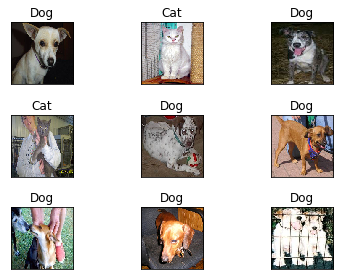

In [69]:
# See some of the training images
import matplotlib.pyplot as plt
% matplotlib inline

dog_or_cat = {1: 'Dog', 0:'Cat'}
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(each[0][i])
  plt.xticks([])
  plt.yticks([])
  plt.title(dog_or_cat[each[1][i]])
plt.tight_layout()

## Building the Model

We will use 3 modules. Each module will have {convolutional layer, relu activation, maxpooling}. Using only 3 modules helps keep the neural network shallow to prevent overfitting (because the size of the dataset is small).

In the first module we will use 16 filters, 32 filters in the second and 64 in the third. The size of the kernels(filters) for the convolutional layers is 3x3. The size of the maxpooling kernels is 2x2.

In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Flatten, Input
from tensorflow.keras import Model

In [0]:
X_input = Input(shape=(150, 150, 3))

X = Conv2D(16, (3, 3), kernel_initializer='glorot_uniform')(X_input)
X = Activation('relu')(X)
X = MaxPooling2D(pool_size=(2,2))(X)

X = Conv2D(32, (3, 3), kernel_initializer='glorot_uniform')(X)
X = Activation('relu')(X)
X = MaxPooling2D(pool_size=(2, 2))(X)

X = Conv2D(64, (3, 3), kernel_initializer='glorot_uniform')(X)
X = Activation('relu')(X)
X = MaxPooling2D(pool_size=(2, 2))(X)

We will now add 2 fully connected layers. The last layer will have sigmoid activation because we have to solve a binary classification problem.

In [0]:
X = Flatten()(X)

X = Dense(512, activation='relu')(X)

output = Dense(1, activation='sigmoid')(X)
# The output of the sigmoid will be the probability that the image has a label of 1.

model = Model(inputs = X_input, outputs = output)

In [73]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
activation_8 (Activation)    (None, 148, 148, 16)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
activation_9 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 32)        0   

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [75]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,#2000 images = batch_size * steps_per_epoch
                              epochs=15,
                              verbose=2,
                              validation_data=validation_generator,
                              validation_steps=50)#1000 images = batch_size*validation_steps

Epoch 1/15
Epoch 1/15
100/100 - 8s - loss: 0.7638 - acc: 0.5235 - val_loss: 0.6871 - val_acc: 0.6100
Epoch 2/15
Epoch 1/15
100/100 - 7s - loss: 0.6628 - acc: 0.6140 - val_loss: 0.6026 - val_acc: 0.6860
Epoch 3/15
Epoch 1/15
100/100 - 7s - loss: 0.5867 - acc: 0.6945 - val_loss: 0.6115 - val_acc: 0.6640
Epoch 4/15
Epoch 1/15
100/100 - 7s - loss: 0.5116 - acc: 0.7450 - val_loss: 0.5891 - val_acc: 0.6970
Epoch 5/15
Epoch 1/15
100/100 - 7s - loss: 0.4468 - acc: 0.7910 - val_loss: 0.6116 - val_acc: 0.7270
Epoch 6/15
Epoch 1/15
100/100 - 7s - loss: 0.3529 - acc: 0.8465 - val_loss: 0.6448 - val_acc: 0.6810
Epoch 7/15
Epoch 1/15
100/100 - 7s - loss: 0.2665 - acc: 0.8865 - val_loss: 0.8027 - val_acc: 0.6790
Epoch 8/15
Epoch 1/15
100/100 - 7s - loss: 0.1823 - acc: 0.9275 - val_loss: 0.9270 - val_acc: 0.6910
Epoch 9/15
Epoch 1/15
100/100 - 7s - loss: 0.1097 - acc: 0.9600 - val_loss: 1.0661 - val_acc: 0.7230
Epoch 10/15
Epoch 1/15
100/100 - 7s - loss: 0.0465 - acc: 0.9835 - val_loss: 1.4176 - val_a

We see that although we are able to achieve a test accuracy of 99.75%, the validation accuracy is just 69.7%. This happens because of overfitting, as our training set is very small.

Before we apply methods like regularization etc., to combat overfitting, let us see what kind of features our model is learning by looking at the intermediate results.

## Visualizing intermediate representations

Each row is the output of a layer. Each image is the output of one filter. We are seeing what happens in each step to some randomly chosen image.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


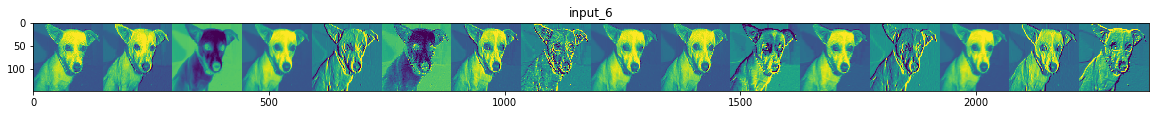

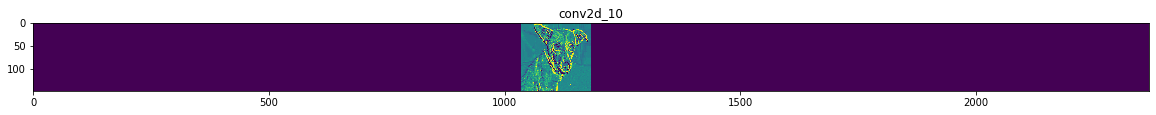

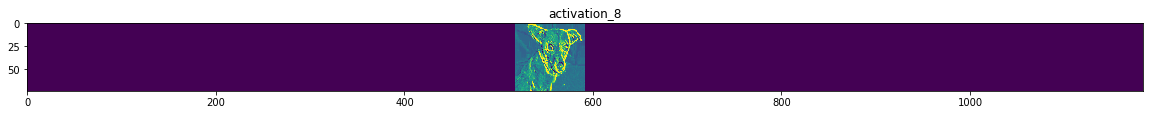

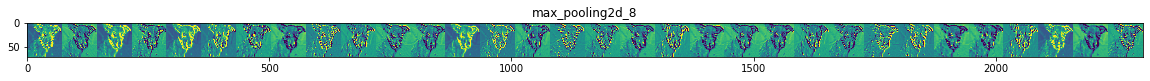

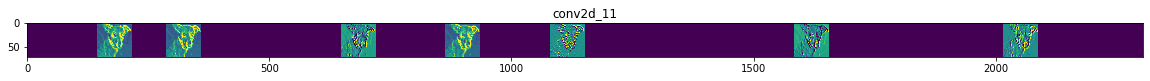

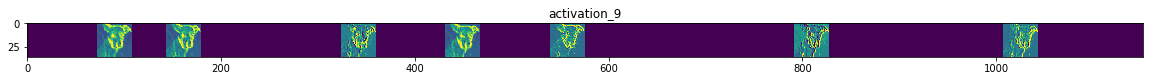

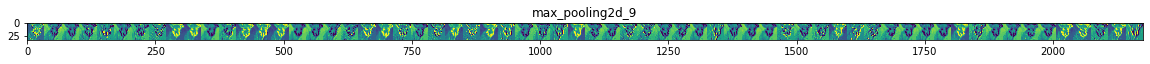

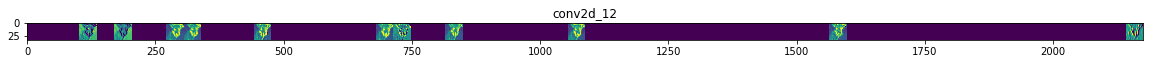

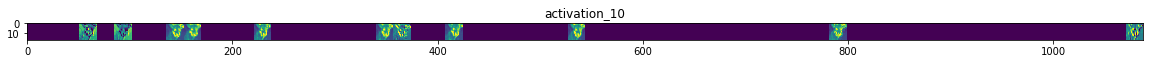

In [80]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(X_input, successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
# cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
# dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
# img_path = random.choice(cat_img_files + dog_img_files)

# img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
# x = img_to_array(img)  # Numpy array with shape (150, 150, 3)

x = each[0][0]
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

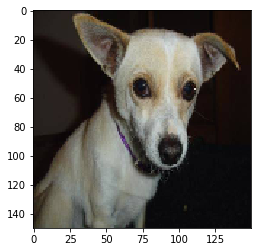

In [79]:
plt.imshow(each[0][0])